1. Installing MNE and MNE_CONNECTIVITY

In [ ]:
!pip install mne
!pip install mne_connectivity

2. Importing modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import mne_connectivity
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

3. Generating synthetic data to test mne

In [ ]:
##Defining a function that takes the time, sampling frequency, and frequency of the oscillation and returns a epoch of generated LFP data

def generate_epoch(end_time, fs, osc_freq, osc_time_start, osc_time_end):

    times = np.arange(0, end_time, 1/fs)

    osc = np.sin(2 * np.pi * times[:] * osc_freq)[osc_time_start:osc_time_end]
    trials = 10
    epochs = np.empty((trials, 2, len(times)))
    plt.figure(figsize=(16,4))

    for trial in range(0, trials):
        lfp1 = np.random.normal(0, .2, size=times.shape)
        lfp2 = np.random.normal(0, .2, size=times.shape)
        lfp1[osc_time_start:osc_time_end] += osc
        lfp2[osc_time_start:osc_time_end] += osc
        epochs[trial, 0, :] = lfp1
        epochs[trial, 1, :] = lfp2
        plt.plot(times, lfp1, label='lfp1', color='blue', alpha=0.1)
        plt.plot(times, lfp2, label='lfp2', color='red', alpha=0.1)
    plt.plot(times, np.mean(epochs[0,:,:], axis=0), color='blue', label='lfp1')
    plt.plot(times, np.mean(epochs[1,:,:], axis=0), color='red',label='lfp2')
    return epochs, times

thirty_epoch, thirty_times=generate_epoch(2, 1000, 30, 750, 1250)
ten_epoch,ten_times=generate_epoch(2, 1000, 30, 500, 850)

3.2 Now we test the coherence function on the generated data

In [ ]:
fs=1000
freqs = np.arange(1,100)
n_cycles = freqs/2
con = mne_connectivity.spectral_connectivity_epochs(ten_epoch, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))                                                   
coh = con.get_data()

plt.imshow(np.squeeze(coh), extent=[ten_times[0], ten_times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

3.3 Trying to take a average of the coherence to see how averaging works

In [ ]:
epoch_1, times_1 = generate_epoch(2, 1000, 30, 750, 1250)
epoch_2, times_2 = generate_epoch(2, 1000, 10, 750, 1250)

fs=1000
freqs = np.arange(1,100)
n_cycles = freqs/2
con_1 = mne_connectivity.spectral_connectivity_epochs(epoch_1, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))

con_2 = mne_connectivity.spectral_connectivity_epochs(epoch_2, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))

coh_1 = con_1.get_data()
coh_2 = con_2.get_data()

print(coh_1.shape)
print(coh_2.shape)

new_array= np.array([coh_1, coh_2])
print(new_array.shape)
new_array_mean = np.mean(new_array, axis=0)
new_array_sum = np.sum(new_array, axis=0)

# Compare the mean and sum arrays element-wise
if np.array_equal(new_array_mean, new_array_sum):
    print('The mean and sum are the same')
else:
    print('The mean and sum are different')

print(new_array_mean.shape)
print(new_array_sum.shape)

# Print some values for debugging
print("Mean array values:", new_array_mean)
print("Sum array values:", new_array_sum)
# Determine the common vmin and vmax for the colormap
vmin = min(np.min(coh_1), np.min(coh_2), np.min(new_array_mean))#, np.min(new_array_sum))
vmax = max(np.max(coh_1), np.max(coh_2), np.max(new_array_mean))#, np.max(new_array_sum))


fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs = axs.flatten()

im = axs[0].imshow(np.squeeze(coh_1), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('10 Hz')

axs[1].imshow(np.squeeze(coh_2), extent=[times_2[0], times_2[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title('30 Hz')

# axs[2].imshow(np.squeeze(new_array_mean), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
# axs[2].set_title('Mean')

axs[2].imshow(np.squeeze(new_array_sum), extent=[times_2[0], times_2[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Sum')

# # Plot the difference between mean and sum
# difference = new_array_sum - new_array_mean
# axs[4].imshow(np.squeeze(difference), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
# axs[4].set_title('Difference (Sum - Mean)')

for ax in axs:
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

4. Loading up the real data

In [2]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello sinha
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_nocontext_day2.mat',

In [3]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [4]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
scrambled_baseline_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
averaged_data=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
random_baseline_data=[]
for file in files:
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)



        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        print(all_channels)

        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),4000))
        first_event = events_times[0]
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)

                #normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)

                total = notch_filtered_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    [functions.zscore_event_data(event_data, baseline_mean ,baseline_std) for event_data in event_data_list]
                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/2
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
            con_data_df.append(row_list)
        # fs=2000
        # freqs = np.arange(1,100)
        # n_cycles = freqs/2
        # info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
        # mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
        # mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
        # mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
        # mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
        # row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
        # con_data_df.append(row_list)


C:\Users\sinha\Dropbox\CPLab\all_data_mat\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
['LFP1_AON' 'LFP2_AON' 'LFP3_AON' 'LFP4_AON' 'LFP1_vHp' 'LFP2_vHp']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0
4000 4000
4000 4000
48.0
237.771855 120.0 239.46185499999999 48.0
4000 4000
4000 4000
49.0
279.551855 120.0 280.29184999999995 49.0
4000 4000
4000 4000
48.0
348.953855 120.0 349.84385 48.0
4000 4000
4000 4000
49.0
466.78984999999994 120.0 468.25985499999996 49.0
4000 4000
4000 4000
49.0
526.9038549999999 120.0 528.223855 49.0
4000 4000
4000 4000
49.0
570.771855 120.0 571.4418549999999 49.0
4000 4000
4000 4000
48.0
617.237855 120.0 618.4178549999999 48.0
4000 4000
4000 4000
49.0
669.49786 120.0 670.737855 49.0
4000 4000
4000 4000
49.0
705.3358549999999 120.0 706.5758549999999 49.0
4000 40

5. Calculating Spectral connectivity and plotting it. Also plots the average of spectral connectivity in a separate plot

In [ ]:
epoch_data=mne_epoch_dig_before
con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=False)

coh = con.get_data(output='dense')
print(coh.shape)
indices = con.names
print("Connection indices:", indices)
fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
times = np.arange(0, 2, 1/fs)
aon_aon_con=[]
aon_vHp_con=[]
vHp_vHp_con=[]
for i in range(coh.shape[0]):
    for j in range(coh.shape[1]):
        axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
        if 'AON' in indices[i] and 'AON' in indices[j]:
            aon_aon_con.append(coh[i,j,:,:])
        elif 'AON' in indices[j] and 'vHp' in indices[i]:
            aon_vHp_con.append(coh[i,j,:,:])
        elif 'vHp' in indices[i] and 'vHp' in indices[j]:
            vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

def filtered_and_mean_con(con):
    print(' number of connections before filtering',len(con))
    filter_con=[x for x in con if x.any()>0]
    print('number of connections after filtering',len(filter_con))
    filter_con=np.array(filter_con)

    filter_con_mean=np.mean(filter_con, axis=0)
    return filter_con_mean
con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs=axs.flatten()
for i, key in enumerate(con_dict):
    con=con_dict[key]
    con_mean=filtered_and_mean_con(con)
    axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(key)
plt.show()


6. Plotting average connectivity across multiple experiments for a single rat

In [17]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])
print(con_data_df.head())

rat_task_con_data=con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
mne_epoch_dig_before_list=list(rat_task_con_data['mne_epoch_dig_before'])
aon_aon_con=[]
aon_vHp_con=[]
vHp_vHp_con=[]

for epoch_data in mne_epoch_dig_before_list:
#epoch_data=mne_epoch_dig_before
    print(epoch_data)
    con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                    mode='cwt_morlet', cwt_freqs=freqs,
                                                    cwt_n_cycles=n_cycles, verbose=False)

    coh = con.get_data(output='dense')
    print(coh.shape)
    indices = con.names
    print("Connection indices:", indices)
    fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
    times = np.arange(0, 2, 1/fs)
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
            axs[i,j].set_xlabel('Time (s)')
            axs[i,j].set_ylabel('Frequency (Hz)')
            axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
            if 'AON' in indices[i] and 'AON' in indices[j]:
                aon_aon_con.append(coh[i,j,:,:])
            elif 'AON' in indices[j] and 'vHp' in indices[i]:
                aon_vHp_con.append(coh[i,j,:,:])
            elif 'vHp' in indices[i] and 'vHp' in indices[j]:
                vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

def filtered_and_mean_con(con):
    print(' number of connections before filtering',len(con))
    filter_con=[x for x in con if x.any()>0]
    print('number of connections after filtering',len(filter_con))
    filter_con=np.array(filter_con)

    filter_con_mean=np.mean(filter_con, axis=0)
    return filter_con_mean
con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs=axs.flatten()
for i, key in enumerate(con_dict):
    con=con_dict[key]
    con_mean=filtered_and_mean_con(con)
    axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
        aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(key)
plt.show()



7. Now we will compare Aon_vHp connectivity between BWcontext and BWnocontext, through events

  rat_id       task                              mne_epoch_door_before  \
0    dk1  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1    dk5  nocontext  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2    dk6  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
3    dk1  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
4    dk5  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   

                                mne_epoch_door_after  \
0  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2  <EpochsArray | 10 events (all good), 0 – 2 s (...   
3  <EpochsArray | 10 events (all good), 0 – 2 s (...   
4  <EpochsArray | 10 events (all good), 0 – 2 s (...   

                                mne_epoch_dig_before  \
0  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2  <EpochsArray | 10 events (all good), 0 – 2 s (.

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>
['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.51860427, 

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['BWnocontext', array([[0.53977495, 0.54045906, 0.54114646, ..., 0.45068326, 0.45050019,
        0.45030959],
       [0.50391601, 0.50422955, 0.50454899, ..., 0.40211882, 0.40192755,
        0.40173378],
       [0.47582853, 0.47573052, 0.47563553, ..., 0.367694  , 0.36752182,
        0.36734875],
       ...,
       [0.52642733, 0.52663485, 0.52684557, ..., 0.41429721, 0.41357477,
        0.41285179],
       [0.52356154, 0.52371228, 0.52386439, ..., 0.41907299, 0.41845419,
        0.41783465],
       [0.49979493, 0.49976668, 0.49973772, ..., 0.42679894, 0.42629316,
        0.42578608]]), array([[0.42883868, 0.42925459, 0.42966485, ..., 0.75866603, 0.75852624,
        0.75838493],
       [0.38889394, 0.38933897, 0.389785  , ..., 0.722462  , 0.72253418,
        0.722606  ],
       [0.35846615, 0.35885935, 0.35925755, ..., 0.66800196, 0.66858003,
        0.66915185],
       ...,
       [0.48408116, 0.48410884, 0.48413826, ..., 0.59618331, 0.5963275 ,
        0.59646896],
       [0.49597226

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmin = all_con_data_df[event_list].applymap(np.min).min().min()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\3342038273.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmax = all_con_data_df[event_list].applymap(np.max).max().max()


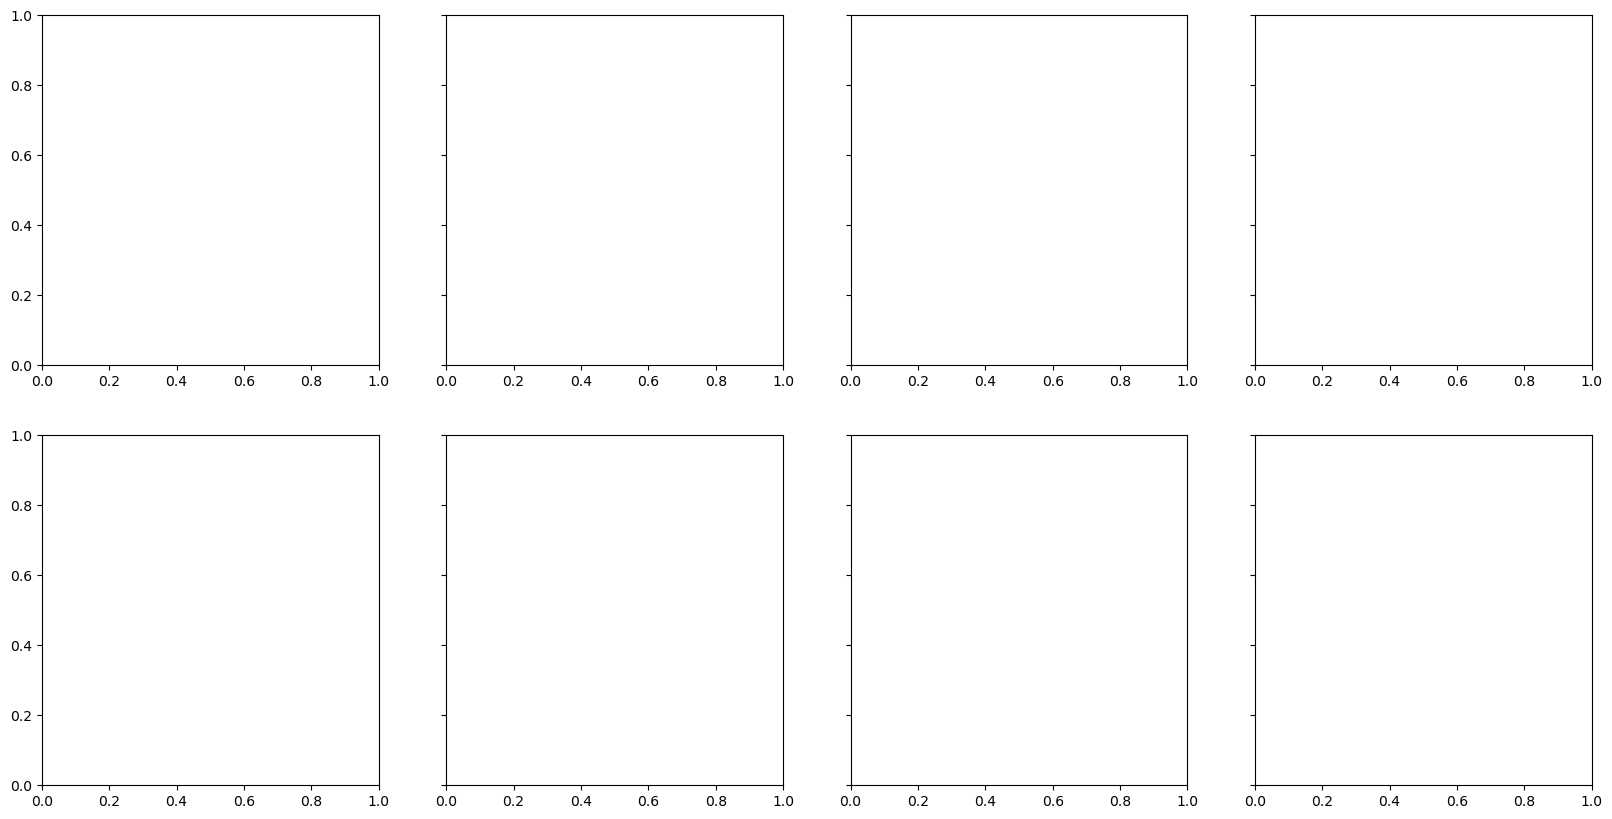

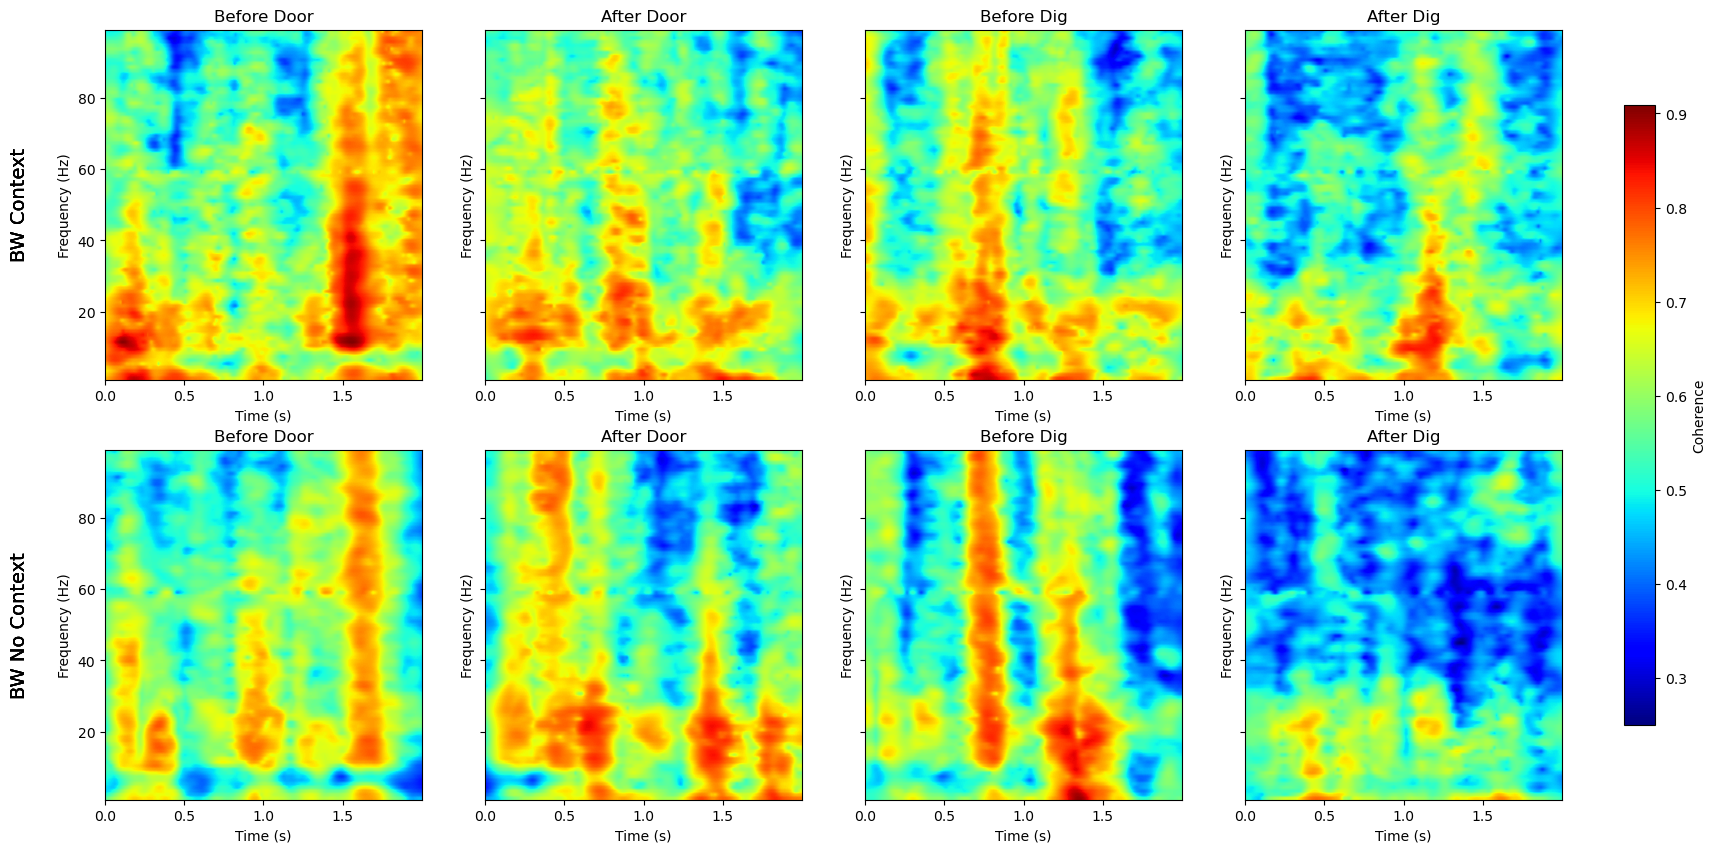

In [5]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])
print(con_data_df.head())

event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

print(event_list)

BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
all_con_data=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        
        for event in event_list:
            #print(event)
            event_epoch_list=list(task_data[event])
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    print(row,event, event_epoch)        
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                aon_vHp_con.append(coh[i,j,:,:])
            row.append(np.mean(aon_vHp_con, axis=0))
        all_con_data.append(row)                    

# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=[ 'task'] + event_list)

times=np.arange(0, 2, 1/fs)
fs=2000
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')

Do this for each rat

  rat_id       task                              mne_epoch_door_before  \
0    dk1  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1    dk5  nocontext  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2    dk6  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
3    dk1  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   
4    dk5  nocontext  <EpochsArray | 10 events (all good), 0 – 2 s (...   

                                mne_epoch_door_after  \
0  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2  <EpochsArray | 10 events (all good), 0 – 2 s (...   
3  <EpochsArray | 10 events (all good), 0 – 2 s (...   
4  <EpochsArray | 10 events (all good), 0 – 2 s (...   

                                mne_epoch_dig_before  \
0  <EpochsArray | 10 events (all good), 0 – 2 s (...   
1  <EpochsArray | 9 events (all good), 0 – 2 s (b...   
2  <EpochsArray | 10 events (all good), 0 – 2 s (.

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk1', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext']
['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk3', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]]), array([[0.52801223, 0.52868578, 0.52935694, ..., 0.60270254, 0.6025141 ,
        0.6023222 ],
       [0.53728132, 0.53780326, 0.53832626, ..., 0.59112673, 0.59080531,
        0.59048212],
       [0.55258659, 0.55297863, 0.55337192, ..., 0.57583026, 0.57549161,
        0.57515228],
       ...,
       [0.49310517, 0.49330455, 0.49350665, ..., 0.42908908, 0.42897529,
        0.42885867],
       [0.518

C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext']
['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.2 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext'] mne_epoch_door_before <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


['dk5', 'BWcontext', array([[0.71812884, 0.71862201, 0.7191122 , ..., 0.64828705, 0.64741513,
        0.64654824],
       [0.69232372, 0.69283398, 0.69334347, ..., 0.6414111 , 0.64080826,
        0.64021001],
       [0.67577232, 0.67622299, 0.67667284, ..., 0.63550493, 0.63508278,
        0.63466347],
       ...,
       [0.52697268, 0.52687904, 0.52678703, ..., 0.74896864, 0.74880989,
        0.74864616],
       [0.50550832, 0.50527835, 0.50505155, ..., 0.74716037, 0.7469749 ,
        0.74678634],
       [0.497579  , 0.49731214, 0.49704869, ..., 0.74923906, 0.7489641 ,
        0.74868764]])] mne_epoch_door_after <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>


C:\Users\sinha\AppData\Local\Temp\ipykernel_19152\886752981.py:31: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),


KeyboardInterrupt: 

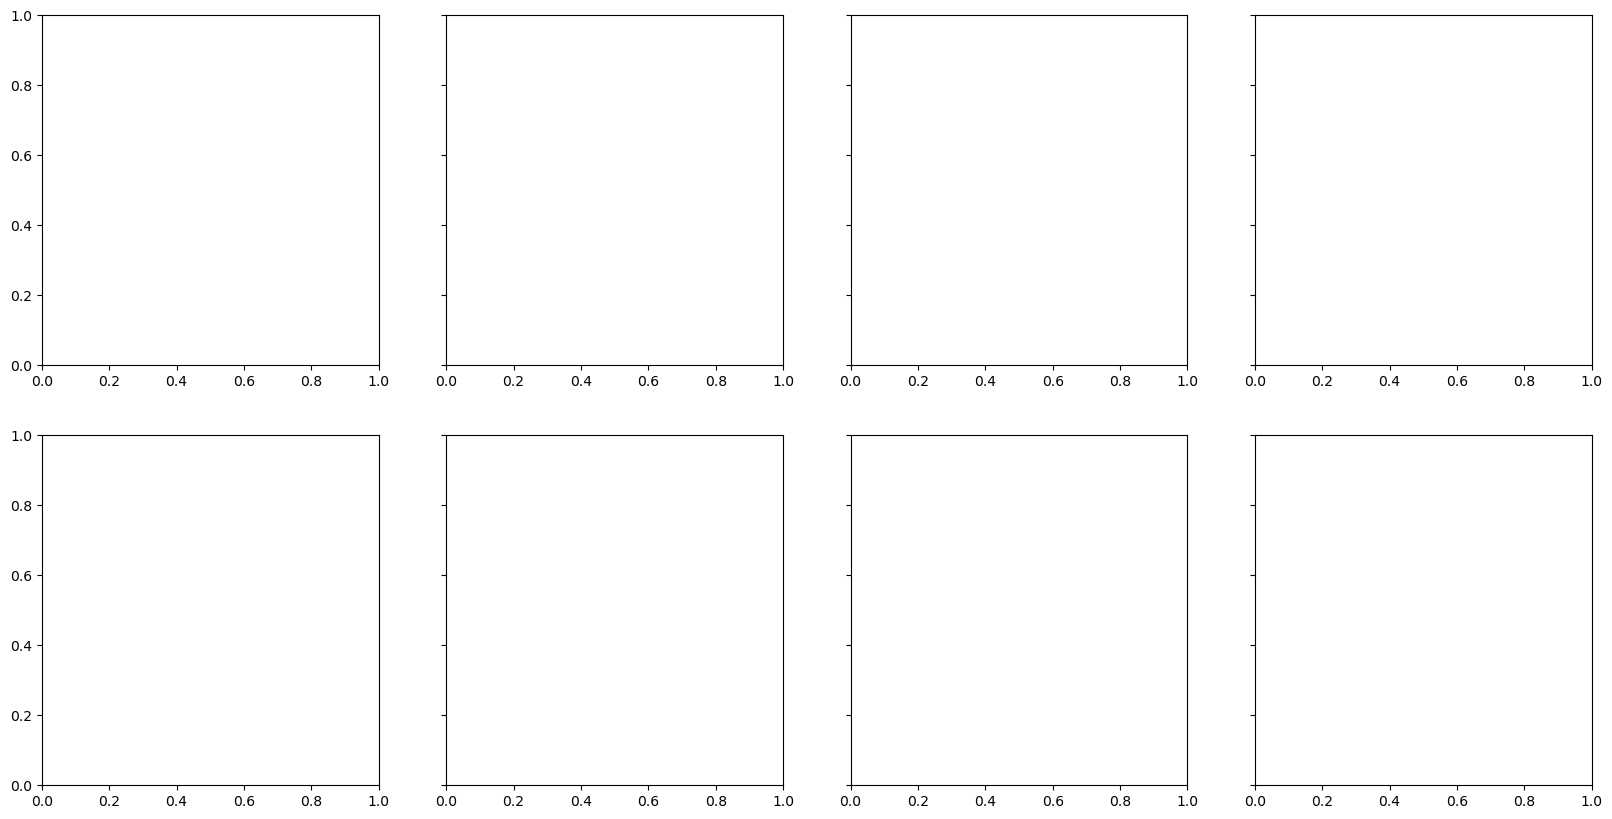

In [6]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])
print(con_data_df.head())

event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

print(event_list)

BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
all_con_data=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
        print(task_name)
        for rat_num, rat_name in enumerate(rat_list):
            rat_task_data=task_data[task_data['rat_id']==rat_name]
            row=[rat_name,task_name]
            print(row)
            
            for event in event_list:
                #print(event)
                event_epoch_list=list(task_data[event])
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        print(row,event, event_epoch)        
                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False)
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    aon_vHp_con.append(coh[i,j,:,:])
                row.append(np.mean(aon_vHp_con, axis=0))
            all_con_data.append(row)                    

# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=[ 'task'] + event_list)

times=np.arange(0, 2, 1/fs)
fs=2000
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')

In [ ]:
import numpy as np
import pandas as pd


# Group by 'task' and calculate the mean for each column
BWcontext_data = all_con_data_df[all_con_data_df['task'] == 'BWcontext']
BWnocontext_data = all_con_data_df[all_con_data_df['task'] == 'BWnocontext']
task_data_dict = {'BWcontext': BWcontext_data, 'BWnocontext': BWnocontext_data}
for task_name in task_data_dict.keys():
    task_data = task_data_dict[task_name]
    # Initialize an empty list to store the values
    all_values = []

    # Iterate over each row in the task_data
    for index, row in task_data.iterrows():
        # Extract the stored values in each column and append to the list
        for event in event_list:
            if pd.all.notnull(row[event]):
                all_values.append(row[event])

    # Convert the list to a numpy array and take the mean
    all_values_array = np.array(all_values)
    task_averages = np.mean(all_values_array, axis=0)
    task_averages = task_data.mean()
    print(task_averages)


In [ ]:


for rati, rat_name in rat_list:

    rat_task_con_data=con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
    mne_epoch_dig_before_list=list(rat_task_con_data['mne_epoch_dig_before'])
    aon_aon_con=[]
    aon_vHp_con=[]
    vHp_vHp_con=[]

    for epoch_data in mne_epoch_dig_before_list:
    #epoch_data=mne_epoch_dig_before
        print(epoch_data)
        con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                        mode='cwt_morlet', cwt_freqs=freqs,
                                                        cwt_n_cycles=n_cycles, verbose=False)

        coh = con.get_data(output='dense')
        print(coh.shape)
        indices = con.names
        print("Connection indices:", indices)
        fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
        times = np.arange(0, 2, 1/fs)
        for i in range(coh.shape[0]):
            for j in range(coh.shape[1]):
                axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
                aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
                axs[i,j].set_xlabel('Time (s)')
                axs[i,j].set_ylabel('Frequency (Hz)')
                axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
                if 'AON' in indices[i] and 'AON' in indices[j]:
                    aon_aon_con.append(coh[i,j,:,:])
                elif 'AON' in indices[j] and 'vHp' in indices[i]:
                    aon_vHp_con.append(coh[i,j,:,:])
                elif 'vHp' in indices[i] and 'vHp' in indices[j]:
                    vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

    def filtered_and_mean_con(con):
        print(' number of connections before filtering',len(con))
        filter_con=[x for x in con if x.any()>0]
        print('number of connections after filtering',len(filter_con))
        filter_con=np.array(filter_con)

        filter_con_mean=np.mean(filter_con, axis=0)
        return filter_con_mean
    con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
    fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
    axs=axs.flatten()
    for i, key in enumerate(con_dict):
        con=con_dict[key]
        con_mean=filtered_and_mean_con(con)
        axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Frequency (Hz)')
        axs[i].set_title(key)
    plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_reshaped = mne_epoch_door_before.reshape(-1, 4000)  # Reshape to (n_epochs * n_channels, n_times)
data_normalized = scaler.fit_transform(data_reshaped)
data_normalized = data_normalized.reshape(len(epochs), len(lfp_channels), 4000)  # Reshape back to (n_epochs, n_channels, n_times)

info = mne.create_info(ch_names=channels, sfreq=2000.0, ch_types='misc')



In [ ]:
# Create MNE EpochsArray
mne_epoch_door_before = mne.EpochsArray(data_normalized, info)

# Plot the data
fig = mne_epoch_door_before.plot(picks=np.arange(1, 8), n_epochs=10)


fig.show()

# info=mne.create_info(ch_names=channels,sfreq=2000.0,ch_types='misc')
# mne_epoch_door_before=mne.EpochsArray(mne_epoch_door_before,info)
# #fig,axs=plt.subplots(1,1,figsize=(30,10))
# fig=mne_epoch_door_before.plot(picks=np.arange(1,8),n_epochs=10)
# fig.show()

In [ ]:
!pip install mne_connectivity

In [ ]:
import mne
import mne_connectivity


In [ ]:
%matplotlib inline
print(coh.shape)
plt.imshow(np.squeeze(coh[,:,:]), extent=[0, 2, freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
print(coh)

In [ ]:
coh = con.get_data()

fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs = axs.flatten()

for i in range(coh.shape[0]):
    im = axs[i].imshow(np.squeeze(coh[i, :, :]), extent=[0, 2, freqs[0], freqs[-1]],
                       aspect='auto', origin='lower', cmap='jet')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title('Channel {}'.format(i))

# Add a colorbar
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()